# Notebook 01 - Data Cleaning & Integrated Exploratory Analysis
**Core Objective:** Transform raw data into a modeling-ready format through iterative visual diagnostics.

This notebook manages the transition from raw data to a modeling-ready format. The workflow integrates exploratory diagnostics to identify structural issues - such as negatively worded items and encoded "special codes" - requiring specific transformations to ensure data integrity.

**Key Technical Workflows:**
* **Feature Engineering:** Aggregates multi-column metrics into unified features and inverts negatively worded items to ensure directional consistency.
* **Imputation Strategy:** Addresses missingness through a combination of median replacement and Iterative Imputation for complex feature relationships.
* **Data Sanitization**: Replaces non-standard codes with NaNs, enforces strict data type conversion, and prunes redundant features to reduce dimensionality.
* **Artifacts:** Exports the finalized dataset to `data/processed/clean_data.csv`.

# 1. Imports

In [9]:
# Setup
from ml_core_utils.config import setup_notebook

# Data handling
import numpy as np
import pandas as pd
from ml_core_utils.data_io import load_data
from ml_core_utils.preprocessing import get_missingness_report

# Visualization
import matplotlib.pyplot as plt

# Feature engineering
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 2. Settings / Configuration

In [5]:
setup_notebook(seed=42)

# 3. Loading data

In [8]:
df_raw, meta = load_data("../data/raw/bkl21d.sav")

In [9]:
df_raw.head(5)

,id,intid,waga_proba,waga_proba_kor,waga_pop,waga_pop_kor,rodzaj,edycja,rok,datawyw,...,pform4t,neet,neet2,form12m,pform12m1,pform12m2,pform12m,nform12m,dokszt_all,dokszt_all_bo
0,6590.0,03540-2021,0.374529,0.379380,3732.470588,3780.814881,1.0,2021.0,2021.0,2021-09-20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,6591.0,02070-2021,0.865094,0.876299,8621.333333,8732.999924,1.0,2021.0,2021.0,2021-09-20,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,6592.0,01987-2021,0.283841,0.287518,2828.700000,2865.338333,1.0,2021.0,2021.0,2021-09-20,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
3,6593.0,01686-2021,1.380901,1.398787,13761.750000,13939.997104,1.0,2021.0,2021.0,2021-09-20,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4,6594.0,04358-2021,0.897526,0.909151,8944.545455,9060.398404,1.0,2021.0,2021.0,2021-09-20,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
variables_info = pd.DataFrame({
    "Variable": meta.column_names,
    "Description": meta.column_labels
})

In [11]:
display(variables_info.head(20))

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łąc...
1,intid,ID wywiadu
2,waga_proba,Waga próby bez korekty przypadków ekstremalnyc...
3,waga_proba_kor,Waga próby z korektą przypadków ekstremalnych ...
4,waga_pop,Waga populacyjna bez korekty przypadków ekstre...
5,waga_pop_kor,Waga populacyjna z korektą przypadków ekstrema...
6,rodzaj,Technika badania
7,edycja,Edycja badania
8,rok,BKL - rok badania
9,datawyw,Data wywiadu


# 4. Column selection and data dictionary

In [12]:
columns_to_use = [
    "id", "wiek", "m1", "woj", "m2", "g8", "wykszt_7k", "p8", "e17", "u8",
    "n11", "j1_02", "j1_03", "j1_04", "j1_05", "j1_06", "j1_07", "j1_08",
    "j1_09", "j1_10", "j3_01", "j3_02", "j3_03", "j3_04", "j3_05", "j3_06",
    "j3_07", "j3_08", "j3_09", "j3_10", "j3_11", "j3_12", "j3_13", "m9_13k",
    "m9d", "m13", "o1_1", "o1_2", "o1_3", "j1_01"
]

In [13]:
columns_in_meta = [c for c in columns_to_use if c in meta.column_names]

In [14]:
df_selected = df_raw[columns_in_meta]

In [15]:
df_selected.head(5)

,id,wiek,m1,woj,m2,g8,wykszt_7k,p8,e17,u8,...,j3_11,j3_12,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01
0,6590.0,59.0,1962.0,14.0,0.0,1.0,2.0,3.0,NaN,NaN,...,4.0,4.0,4.0,6.0,2500.0,3.0,5000.0,6000.0,-7.0,4.0
1,6591.0,19.0,2002.0,10.0,0.0,3.0,3.0,NaN,NaN,4.0,...,1.0,1.0,4.0,7.0,3000.0,5.0,2600.0,7500.0,14000.0,4.0
2,6592.0,37.0,1984.0,10.0,1.0,2.0,7.0,NaN,2.0,NaN,...,1.0,1.0,2.0,3.0,1100.0,4.0,2500.0,3000.0,4500.0,2.0
3,6593.0,25.0,1996.0,6.0,1.0,0.0,4.0,NaN,NaN,3.0,...,5.0,4.0,4.0,9.0,4000.0,2.0,5000.0,5000.0,10000.0,2.0
4,6594.0,24.0,1997.0,14.0,1.0,2.0,6.0,NaN,4.0,4.0,...,1.0,1.0,1.0,9.0,4800.0,5.0,6000.0,7500.0,10000.0,5.0


In [16]:
data_dictionary_df = pd.DataFrame({
    "Column": columns_in_meta,
    "Description": [meta.column_labels[meta.column_names.index(c)] for c in columns_in_meta]
})

In [17]:
data_dictionary_df.head(10)

,Column,Description
0,id,Unikalny identyfikator respondenta w bazie łąc...
1,wiek,Wiek
2,m1,Rok urodzenia respondenta
3,woj,Województwo (symbol terytorialny TERC)
4,m2,Płeć respondenta
5,g8,Główna praca
6,wykszt_7k,Wykształcenie ukończone (6 kat)
7,p8,"Na ile odpowiada praca, biorąc wszystko pod uw..."
8,e17,"Na ile odpowiada praca, biorąc wszystko pod uw..."
9,u8,"Na ile odpowiada praca, biorąc wszystko pod uw..."


In [18]:
data_dictionary_df.to_csv("../data/metadata/data_dictionary.csv", index=False)

# 5. Data cleaning and feature engineering

## 5.0 Cleaning setup: Defining variable groups

In [19]:
j1_variables = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
j3_variables = [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
salary_vars = ['m9d', 'm9_13k']

## 5.1 Inspecting anomalies and data validity

### 5.1.1 Basic descriptive checks

In [20]:
print(df_selected['m9d'].describe())
print("Negative earnings:", (df_selected['m9d'] < 0).sum())

count     1220.000000
mean      4004.907377
std       2722.681496
min          2.000000
25%       2500.000000
50%       3300.000000
75%       4500.000000
max      30000.000000
Name: m9d, dtype: float64
Negative earnings: 0


### 5.1.2 Data types

In [21]:
df_selected.dtypes

id           float64
wiek         float64
m1           float64
woj          float64
m2           float64
g8           float64
wykszt_7k    float64
p8           float64
e17          float64
u8           float64
n11          float64
j1_02        float64
j1_03        float64
j1_04        float64
j1_05        float64
j1_06        float64
j1_07        float64
j1_08        float64
j1_09        float64
j1_10        float64
j3_01        float64
j3_02        float64
j3_03        float64
j3_04        float64
j3_05        float64
j3_06        float64
j3_07        float64
j3_08        float64
j3_09        float64
j3_10        float64
j3_11        float64
j3_12        float64
j3_13        float64
m9_13k       float64
m9d          float64
m13          float64
o1_1         float64
o1_2         float64
o1_3         float64
j1_01        float64
dtype: object

In [22]:
is_integer_m13 = (df_selected['m13'] % 1 == 0).all()
print(f"Column 'm13' contains only integers: {is_integer_m13}")

Column 'm13' contains only integers: False


In [23]:
numeric_df = df_selected.select_dtypes(include="number")
integer_check = numeric_df.apply(lambda col: (col % 1 == 0).all())
print(integer_check)

id            True
wiek          True
m1            True
woj           True
m2            True
g8            True
wykszt_7k    False
p8           False
e17          False
u8           False
n11          False
j1_02        False
j1_03        False
j1_04        False
j1_05        False
j1_06        False
j1_07        False
j1_08        False
j1_09        False
j1_10        False
j3_01        False
j3_02        False
j3_03        False
j3_04        False
j3_05        False
j3_06        False
j3_07        False
j3_08        False
j3_09        False
j3_10        False
j3_11        False
j3_12        False
j3_13        False
m9_13k       False
m9d          False
m13          False
o1_1          True
o1_2          True
o1_3          True
j1_01        False
dtype: bool


In [24]:
integer_columns = integer_check[integer_check].index.tolist()
print("Columns containing only integers:", integer_columns)

Columns containing only integers: ['id', 'wiek', 'm1', 'woj', 'm2', 'g8', 'o1_1', 'o1_2', 'o1_3']


### 5.1.3 Metadata for selected variables

In [25]:
pd.set_option("display.max_colwidth", None)
print(variables_info[variables_info["Variable"].isin(df_selected)])

      Variable  \
0           id   
11         woj   
19          m1   
20        wiek   
25          m2   
35   wykszt_7k   
69          p8   
208        e17   
282         u8   
321        n11   
366         g8   
372      j1_01   
373      j1_02   
374      j1_03   
375      j1_04   
376      j1_05   
377      j1_06   
378      j1_07   
379      j1_08   
380      j1_09   
381      j1_10   
385      j3_01   
386      j3_02   
387      j3_03   
388      j3_04   
389      j3_05   
390      j3_06   
391      j3_07   
392      j3_08   
393      j3_09   
394      j3_10   
395      j3_11   
396      j3_12   
397      j3_13   
486       o1_1   
487       o1_2   
488       o1_3   
822        m9d   
824     m9_13k   
833        m13   

                                                                                 Description  
0                                        Unikalny identyfikator respondenta w bazie łączonej  
11                                                    Województwo (symb

### 5.1.4 Variable distribution overview - j1 and j3

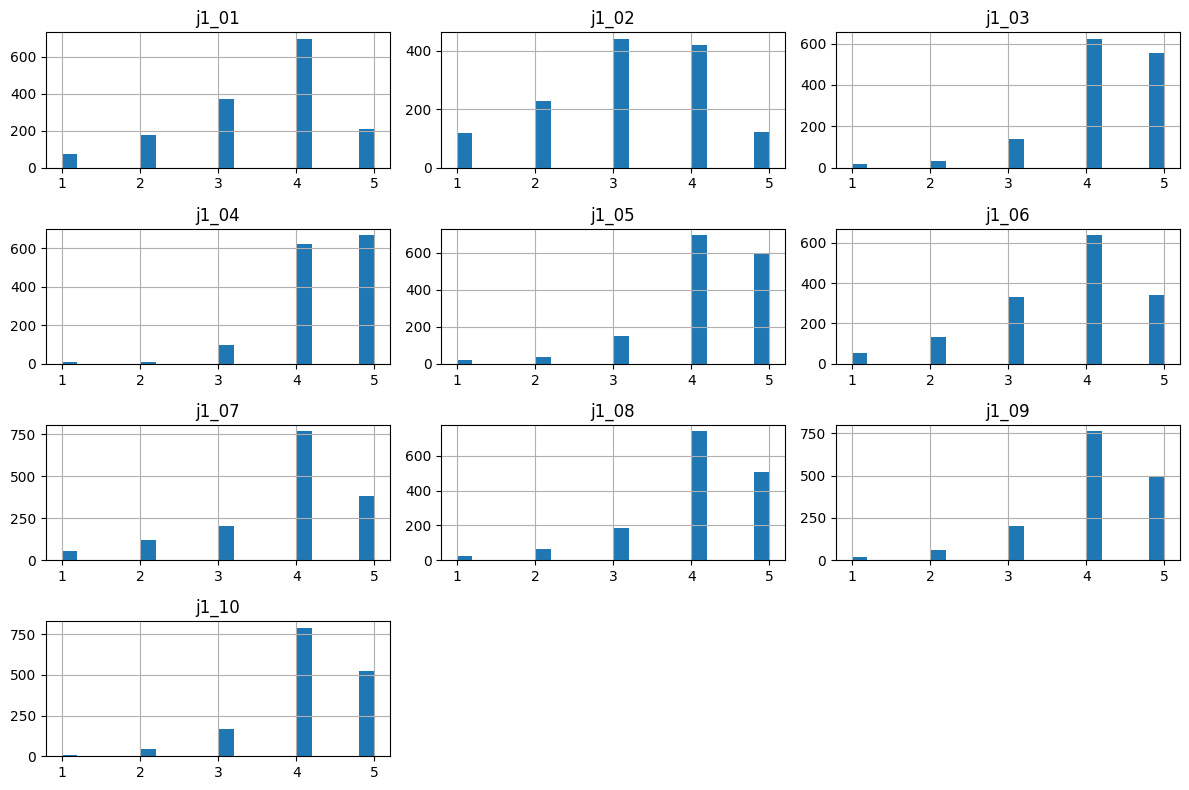

In [26]:
#Checking the skew of j1 variables
df_selected[j1_variables].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

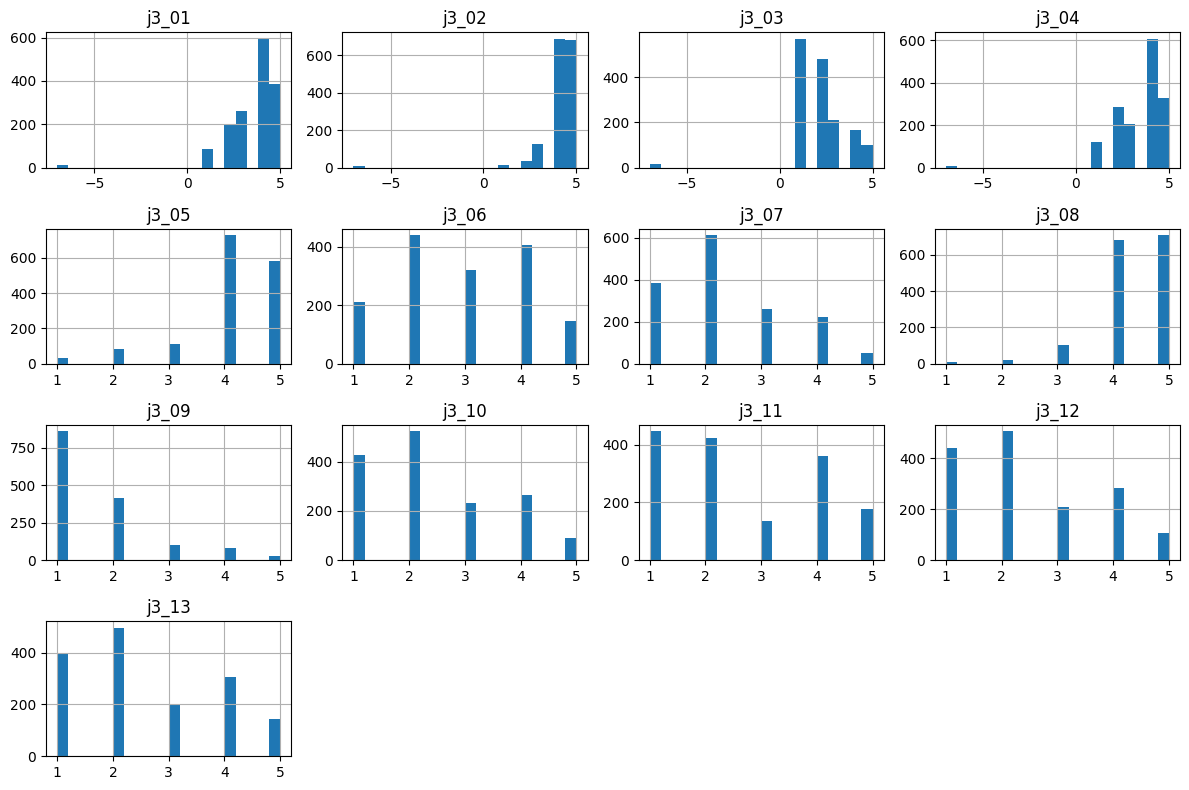

In [27]:
#Checking the skew of j3 variables
df_selected[j3_variables].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

### 5.1.5 Salary variables distribution overview - m9d, m9_13k

In [28]:
#Checking approximate bounds of the distribution
q_low = df_selected['m9d'].quantile(0.01)   
q_high = df_selected['m9d'].quantile(0.99)  
print(q_low, q_high)

250.0 15000.0


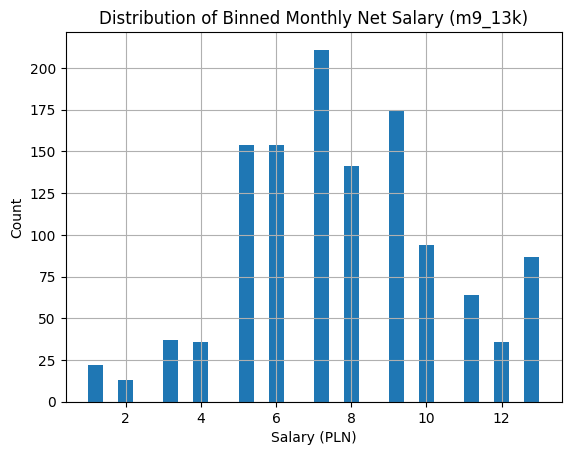

In [29]:
#Inspecting the distribution of monthly net salary (m9_13k)
df_selected['m9_13k'].hist(bins=30)
plt.title("Distribution of Binned Monthly Net Salary (m9_13k)")
plt.xlabel("Salary (PLN)")
plt.ylabel("Count")
plt.show()

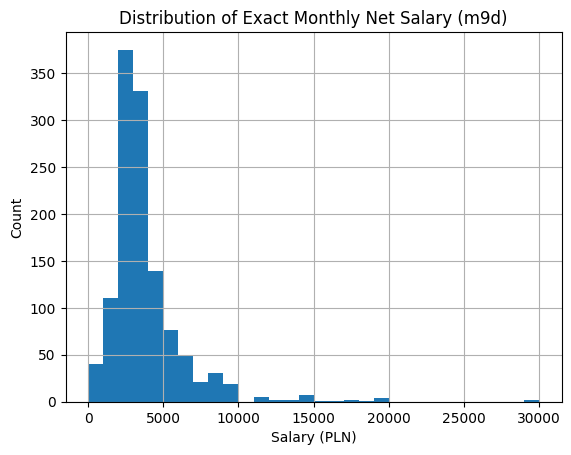

In [30]:
#Inspecting the distribution of monthly net salary (m9d)
df_selected['m9d'].hist(bins=30)
plt.title("Distribution of Exact Monthly Net Salary (m9d)")
plt.xlabel("Salary (PLN)")
plt.ylabel("Count")
plt.show()

In [31]:
pd.set_option("display.max_colwidth", None)
variables_info[variables_info["Variable"].isin(df_selected.columns)]

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łączonej
11,woj,Województwo (symbol terytorialny TERC)
19,m1,Rok urodzenia respondenta
20,wiek,Wiek
25,m2,Płeć respondenta
35,wykszt_7k,Wykształcenie ukończone (6 kat)
69,p8,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"
208,e17,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"
282,u8,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"
321,n11,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"


In [32]:
#Checking the descriptive stats for salary
df_selected['m9d'].describe()

count     1220.000000
mean      4004.907377
std       2722.681496
min          2.000000
25%       2500.000000
50%       3300.000000
75%       4500.000000
max      30000.000000
Name: m9d, dtype: float64

In [33]:
df_selected['m9_13k'].isna().sum()

np.int64(1306)

In [34]:
#checking - add missingness overview
df_selected.columns

Index(['id', 'wiek', 'm1', 'woj', 'm2', 'g8', 'wykszt_7k', 'p8', 'e17', 'u8',
       'n11', 'j1_02', 'j1_03', 'j1_04', 'j1_05', 'j1_06', 'j1_07', 'j1_08',
       'j1_09', 'j1_10', 'j3_01', 'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06',
       'j3_07', 'j3_08', 'j3_09', 'j3_10', 'j3_11', 'j3_12', 'j3_13', 'm9_13k',
       'm9d', 'm13', 'o1_1', 'o1_2', 'o1_3', 'j1_01'],
      dtype='object')

In [35]:
#checking - add missingness overview
for column in df_selected:
    print(column)
    print(df_selected[column].isna().sum())

id
0
wiek
0
m1
0
woj
0
m2
0
g8
0
wykszt_7k
5
p8
2206
e17
1372
u8
2307
n11
2427
j1_02
1197
j1_03
1165
j1_04
1123
j1_05
1027
j1_06
1031
j1_07
999
j1_08
1009
j1_09
995
j1_10
992
j3_01
990
j3_02
979
j3_03
982
j3_04
983
j3_05
991
j3_06
1001
j3_07
994
j3_08
1008
j3_09
1044
j3_10
991
j3_11
986
j3_12
987
j3_13
991
m9_13k
1306
m9d
1309
m13
64
o1_1
0
o1_2
0
o1_3
0
j1_01
995


## 5.2 Filtering employment types (g8)

In [36]:
df_selected["g8"].unique()

array([1., 3., 2., 0., 4., 5., 6.])

In [37]:
df_selected = df_selected[
    (df_selected['g8'] > 1) & (df_selected['g8'] < 5)
]

In [38]:
df_selected.head(5)

,id,wiek,m1,woj,m2,g8,wykszt_7k,p8,e17,u8,...,j3_11,j3_12,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01
1,6591.0,19.0,2002.0,10.0,0.0,3.0,3.0,NaN,NaN,4.0,...,1.0,1.0,4.0,7.0,3000.0,5.0,2600.0,7500.0,14000.0,4.0
2,6592.0,37.0,1984.0,10.0,1.0,2.0,7.0,NaN,2.0,NaN,...,1.0,1.0,2.0,3.0,1100.0,4.0,2500.0,3000.0,4500.0,2.0
4,6594.0,24.0,1997.0,14.0,1.0,2.0,6.0,NaN,4.0,4.0,...,1.0,1.0,1.0,9.0,4800.0,5.0,6000.0,7500.0,10000.0,5.0
8,6598.0,49.0,1972.0,24.0,1.0,2.0,5.0,NaN,4.0,NaN,...,1.0,1.0,1.0,10.0,5000.0,4.0,3500.0,5500.0,6500.0,4.0
11,6601.0,46.0,1975.0,22.0,1.0,2.0,7.0,NaN,2.0,NaN,...,2.0,3.0,4.0,10.0,5000.0,NaN,-7.0,-7.0,-7.0,2.0


## 5.3 Constructing a satisfaction variable (unified)

Initialize satisfaction column

In [39]:
satisfaction_columns = ['p8','e17','u8','n11']
df_selected['satisfaction'] = np.nan

Assign satisfaction based on main employment type (g8)

In [40]:
g8_to_satisfaction_column = {1:'p8', 2:'e17', 3:'u8', 4:'n11'}

In [41]:
df_selected['satisfaction'] = (
    df_selected.apply(
        lambda row: row[g8_to_satisfaction_column[row['g8']]], 
           axis=1)
)

In [42]:
pd.set_option("display.max_colwidth", None)
print(variables_info[variables_info["Variable"].isin(df_selected)])

      Variable  \
0           id   
11         woj   
19          m1   
20        wiek   
25          m2   
35   wykszt_7k   
69          p8   
208        e17   
282         u8   
321        n11   
366         g8   
372      j1_01   
373      j1_02   
374      j1_03   
375      j1_04   
376      j1_05   
377      j1_06   
378      j1_07   
379      j1_08   
380      j1_09   
381      j1_10   
385      j3_01   
386      j3_02   
387      j3_03   
388      j3_04   
389      j3_05   
390      j3_06   
391      j3_07   
392      j3_08   
393      j3_09   
394      j3_10   
395      j3_11   
396      j3_12   
397      j3_13   
486       o1_1   
487       o1_2   
488       o1_3   
822        m9d   
824     m9_13k   
833        m13   

                                                                                 Description  
0                                        Unikalny identyfikator respondenta w bazie łączonej  
11                                                    Województwo (symb

## 5.4 Dropping rows with missing satisfaction

In [43]:
df_selected = df_selected.dropna(subset=['satisfaction'])

Drop original satisfaction columns (p8, e17, u8, n11)

In [44]:
df_selected = df_selected.drop(columns=satisfaction_columns)

In [45]:
df_selected.head(5)

,id,wiek,m1,woj,m2,g8,wykszt_7k,j1_02,j1_03,j1_04,...,j3_12,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01,satisfaction
1,6591.0,19.0,2002.0,10.0,0.0,3.0,3.0,4.0,5.0,5.0,...,1.0,4.0,7.0,3000.0,5.0,2600.0,7500.0,14000.0,4.0,4.0
2,6592.0,37.0,1984.0,10.0,1.0,2.0,7.0,2.0,3.0,4.0,...,1.0,2.0,3.0,1100.0,4.0,2500.0,3000.0,4500.0,2.0,2.0
4,6594.0,24.0,1997.0,14.0,1.0,2.0,6.0,5.0,5.0,5.0,...,1.0,1.0,9.0,4800.0,5.0,6000.0,7500.0,10000.0,5.0,4.0
8,6598.0,49.0,1972.0,24.0,1.0,2.0,5.0,3.0,5.0,5.0,...,1.0,1.0,10.0,5000.0,4.0,3500.0,5500.0,6500.0,4.0,4.0
11,6601.0,46.0,1975.0,22.0,1.0,2.0,7.0,3.0,5.0,5.0,...,3.0,4.0,10.0,5000.0,NaN,-7.0,-7.0,-7.0,2.0,2.0


## 5.5 Checking remaining missing values

In [46]:
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1202 entries, 1 to 2527
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1202 non-null   float64
 1   wiek          1202 non-null   float64
 2   m1            1202 non-null   float64
 3   woj           1202 non-null   float64
 4   m2            1202 non-null   float64
 5   g8            1202 non-null   float64
 6   wykszt_7k     1200 non-null   float64
 7   j1_02         1112 non-null   float64
 8   j1_03         1193 non-null   float64
 9   j1_04         1188 non-null   float64
 10  j1_05         1191 non-null   float64
 11  j1_06         1181 non-null   float64
 12  j1_07         1193 non-null   float64
 13  j1_08         1188 non-null   float64
 14  j1_09         1197 non-null   float64
 15  j1_10         1199 non-null   float64
 16  j3_01         1193 non-null   float64
 17  j3_02         1202 non-null   float64
 18  j3_03         1201 non-null   flo

In [47]:
get_missingness_report(df_selected, variables_info)

,missing_count,missing_pct,description
m9d,239,19.883527,Przeciętne miesięczne zarobki netto w ost. 12m - dokładne (uwzgl. dane przedziałowe)
m9_13k,236,19.633943,Przeciętne miesięczne zarobki netto w ost. 12m - przedział (uwzgl. dane dokładne)
j1_02,90,7.487521,Zadowolenie: Możliwości awansu
m13,23,1.913478,Przy aktualnym dochodzie gosp. domowego związanie końca z końcem jest…
j1_06,21,1.747088,Zadowolenie: Możliwość rozwoju osobistego i podnoszenia umiejętności
j1_08,14,1.164725,Zadowolenie: Możliwość wykazania się inicjatywą i samodzielnością
j1_04,14,1.164725,Zadowolenie: Kontakty ze współpracownikami
j3_06,11,0.915141,"Często muszę wykonywać zadania, które są zbyt proste w stosunku do moich umiejętności"
j1_05,11,0.915141,Zadowolenie: Pewność zatrudnienia
j1_03,9,0.748752,Zadowolenie: Relacje z przełożonymi


## 5.6 Inverting negatively worded J3 items

In [48]:
survey_labels = variables_info[variables_info["Variable"].isin(df_selected.columns)]
survey_labels

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łączonej
11,woj,Województwo (symbol terytorialny TERC)
19,m1,Rok urodzenia respondenta
20,wiek,Wiek
25,m2,Płeć respondenta
35,wykszt_7k,Wykształcenie ukończone (6 kat)
366,g8,Główna praca
372,j1_01,Zadowolenie: Zarobki
373,j1_02,Zadowolenie: Możliwości awansu
374,j1_03,Zadowolenie: Relacje z przełożonymi


In [49]:
negative_items = ["j3_03", "j3_06", "j3_07", "j3_09", "j3_10", "j3_11", "j3_12", "j3_13"]

In [50]:
df_selected[negative_items].head()

,j3_03,j3_06,j3_07,j3_09,j3_10,j3_11,j3_12,j3_13
1,2.0,4.0,1.0,1.0,1.0,1.0,1.0,4.0
2,4.0,3.0,2.0,2.0,4.0,1.0,1.0,2.0
4,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
8,1.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0
11,1.0,2.0,1.0,1.0,4.0,2.0,3.0,4.0


In [51]:
min_val = 1
max_val = 5

df_selected[negative_items] = df_selected[negative_items].apply(lambda x: (max_val + min_val) - x)

In [52]:
df_selected[negative_items].head()

,j3_03,j3_06,j3_07,j3_09,j3_10,j3_11,j3_12,j3_13
1,4.0,2.0,5.0,5.0,5.0,5.0,5.0,2.0
2,2.0,3.0,4.0,4.0,2.0,5.0,5.0,4.0
4,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0
8,5.0,3.0,4.0,5.0,4.0,5.0,5.0,5.0
11,5.0,4.0,5.0,5.0,2.0,4.0,3.0,2.0


## 5.7 Handling missing values

### 5.7.0 Setup

In [53]:
special_codes = [-8, -7, -3, -1, 8, 13]

### 5.7.1 Education variable (wykszt_7k)

Ordinal categorical variable. Missing values imputed using the mode.

In [54]:
df_selected["wykszt_7k"] = df_selected["wykszt_7k"].fillna(df_selected["wykszt_7k"].mode()[0])

### 5.7.2 Likert satisfaction items (j1_01–j1_10)

These are 10 job-satisfaction items measured on a 1–5 Likert scale. Missing data are imputed using the median due to ordinal scale and moderate skew.

In [55]:
#Diagnostics
df_selected[j1_variables].isna().sum()

j1_01     5
j1_02    90
j1_03     9
j1_04    14
j1_05    11
j1_06    21
j1_07     9
j1_08    14
j1_09     5
j1_10     3
dtype: int64

In [56]:
#Imputing ordinal Likert items with the median
df_selected[j1_variables] = df_selected[j1_variables].fillna(
    df_selected[j1_variables].median()
)

### 5.7.3 Likert job statements (j3_01–j3_13)

Ordinal Likert-scale items (1–5) measuring agreement on job-related statements.  
Some variables contain special negative codes indicating nonresponse (e.g., -8 = "don’t know").

In [57]:
print(j3_variables)

['j3_01', 'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06', 'j3_07', 'j3_08', 'j3_09', 'j3_10', 'j3_11', 'j3_12', 'j3_13']


In [58]:
for col in ["j3_01", "j3_02", "j3_03", "j3_04"]:
    label_set = meta.variable_value_labels.get(col)
    print(f"{col}: {label_set if label_set else 'no value labels found'}")

j3_01: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
j3_02: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
j3_03: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
j3_04: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}


In [59]:
#Recoding special negative codes (-8, -7, -3, -1) to NaN in j3_01-j3_04
for col in ["j3_01", "j3_02", "j3_03", "j3_04"]:
    df_selected[col] = df_selected[col].replace(special_codes, np.nan)

In [60]:
#Imputing missing values with median
df_selected[j3_variables] = df_selected[j3_variables].fillna(df_selected[j3_variables].median())

### 5.7.4 m13 — Difficulty making ends meet

This variable measures how difficult respondents find it to make ends meet with their current salary.  

In [61]:
df_selected["m13"] = df_selected["m13"].replace(special_codes, np.nan)
print(f"Missing values in m13 after recoding: {df_selected['m13'].isna().sum()}")

Missing values in m13 after recoding: 23


In [62]:
print(sorted(df_selected['m13'].dropna().unique()))

[np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0)]


In [63]:
df_selected['m13'] = df_selected['m13'].fillna(df_selected['m13'].median())

In [64]:
df_selected['j3_03'].unique()

array([4., 2., 5., 3., 1.])

### 5.7.5 Salary variables — m9d (exact net salary) and m9_13k (binned salary)

In [65]:
salary_vars = [
    'm9d',
    'm9_13k'
    ]

In [66]:
income_prediction_columns = [
    'wiek',
    'm2',
    'wykszt_7k',
    'j1_01',
    'j1_02',
    'j1_05',
    'j3_05',
    'satisfaction'
]

In [67]:
#Removing all rows under minimum hourly rate for civil-law contracts (likely mis-coded entries)
#Retain high earners, since top values (30000pln) are plausible in general population
before = len(df_selected)
df_selected = df_selected[
    (df_selected['m9d'].isna()) | (df_selected['m9d'] >= 30.5)
]
after = len(df_selected)

print(f"Removed {before - after} rows with unrealistic salary values (<30.5 PLN).")

Removed 1 rows with unrealistic salary values (<30.5 PLN).


In [68]:
#overlap between two variables
missing_exact = df_selected['m9d'].isnull()
missing_binned = df_selected['m9_13k'].isnull()

#a count of missing values
total_missing_exact = missing_exact.sum()
total_missing_binned = missing_binned.sum()

In [69]:
overlap_mask = missing_exact & missing_binned
num_overlap = overlap_mask.sum()

In [70]:
print(num_overlap)
print(total_missing_binned)
print(total_missing_exact)

236
236
239


In [71]:
imputation_columns = income_prediction_columns +  salary_vars

In [72]:
print(df_selected[imputation_columns].dtypes)

wiek            float64
m2              float64
wykszt_7k       float64
j1_01           float64
j1_02           float64
j1_05           float64
j3_05           float64
satisfaction    float64
m9d             float64
m9_13k          float64
dtype: object


In [73]:
impute_df = df_selected[imputation_columns].copy() #temporary imputation dataframe

In [74]:
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=15,
    random_state=42,
    min_value=30.5, #minimum hourly wage in Poland
    max_value=None
)

In [75]:
df_imputed_temp = pd.DataFrame( #temporary imputation dataframe
    imputer.fit_transform(impute_df),  
    columns=impute_df.columns,
    index=impute_df.index
    )

In [76]:
df_selected['m9d'] = df_imputed_temp['m9d']
df_selected['m9_13k'] = df_imputed_temp['m9_13k']

In [77]:
print("Missing values after imputation:")
print(df_selected[['m9d', 'm9_13k']].isnull().sum())

Missing values after imputation:
m9d       0
m9_13k    0
dtype: int64


## 5.8 Data type conversion

In [78]:
numeric_df = df_selected.select_dtypes(include="number")

In [79]:
candidate_integer_cols = [col for col in numeric_df.columns if col not in ['m9d', 'm9_13k']]

In [80]:
integer_check = numeric_df[candidate_integer_cols].apply(lambda col: (col % 1 == 0).all())
integer_columns = integer_check[integer_check].index.tolist()
print("Columns containing only integers (safe to convert):", integer_columns)

Columns containing only integers (safe to convert): ['id', 'wiek', 'm1', 'woj', 'm2', 'g8', 'wykszt_7k', 'j1_02', 'j1_03', 'j1_04', 'j1_05', 'j1_06', 'j1_07', 'j1_08', 'j1_09', 'j1_10', 'j3_01', 'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06', 'j3_07', 'j3_08', 'j3_09', 'j3_10', 'j3_11', 'j3_12', 'j3_13', 'm13', 'o1_1', 'o1_2', 'o1_3', 'j1_01', 'satisfaction']


In [81]:
integer_columns.remove('satisfaction')
print(integer_columns)

['id', 'wiek', 'm1', 'woj', 'm2', 'g8', 'wykszt_7k', 'j1_02', 'j1_03', 'j1_04', 'j1_05', 'j1_06', 'j1_07', 'j1_08', 'j1_09', 'j1_10', 'j3_01', 'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06', 'j3_07', 'j3_08', 'j3_09', 'j3_10', 'j3_11', 'j3_12', 'j3_13', 'm13', 'o1_1', 'o1_2', 'o1_3', 'j1_01']


In [82]:
df_selected[integer_columns] = df_selected[integer_columns].astype("int64")

In [83]:
df_selected.dtypes

id                int64
wiek              int64
m1                int64
woj               int64
m2                int64
g8                int64
wykszt_7k         int64
j1_02             int64
j1_03             int64
j1_04             int64
j1_05             int64
j1_06             int64
j1_07             int64
j1_08             int64
j1_09             int64
j1_10             int64
j3_01             int64
j3_02             int64
j3_03             int64
j3_04             int64
j3_05             int64
j3_06             int64
j3_07             int64
j3_08             int64
j3_09             int64
j3_10             int64
j3_11             int64
j3_12             int64
j3_13             int64
m9_13k          float64
m9d             float64
m13               int64
o1_1              int64
o1_2              int64
o1_3              int64
j1_01             int64
satisfaction    float64
dtype: object

## 5.9 Feature engineering

In [84]:
def assign_generation(year):
    if 1946 <= year <= 1964:
        return 'BB'
    elif 1965 <= year <= 1980:
        return 'X'
    elif 1981 <= year <= 1994:
        return 'M'
    elif 1995 <= year <= 2010:
        return 'Z'
    elif year >= 2011:
        return 'A'
    else:
        return np.nan 

In [85]:
df_selected['generation'] = df_selected['m1'].apply(assign_generation)

In [86]:
df_selected['generation'].isna().sum()

np.int64(0)

In [87]:
df_selected.isna().sum()

id              0
wiek            0
m1              0
woj             0
m2              0
g8              0
wykszt_7k       0
j1_02           0
j1_03           0
j1_04           0
j1_05           0
j1_06           0
j1_07           0
j1_08           0
j1_09           0
j1_10           0
j3_01           0
j3_02           0
j3_03           0
j3_04           0
j3_05           0
j3_06           0
j3_07           0
j3_08           0
j3_09           0
j3_10           0
j3_11           0
j3_12           0
j3_13           0
m9_13k          0
m9d             0
m13             0
o1_1            0
o1_2            0
o1_3            0
j1_01           0
satisfaction    0
generation      0
dtype: int64

## 5.10 Post-cleaning diagnostics

In [88]:
df_selected[j1_variables].isna().sum()

j1_01    0
j1_02    0
j1_03    0
j1_04    0
j1_05    0
j1_06    0
j1_07    0
j1_08    0
j1_09    0
j1_10    0
dtype: int64

In [89]:
df_selected[j3_variables].isna().sum()

j3_01    0
j3_02    0
j3_03    0
j3_04    0
j3_05    0
j3_06    0
j3_07    0
j3_08    0
j3_09    0
j3_10    0
j3_11    0
j3_12    0
j3_13    0
dtype: int64

In [90]:
print("Number of negative salaries after imputation:", (df_selected['m9d'] < 0).sum())

Number of negative salaries after imputation: 0


In [91]:
print(df_selected['m9d'].describe()) 
print((df_selected['m9d'] < 0).sum())

count     1201.000000
mean      7555.485498
std       7671.748349
min         30.500000
25%       2800.000000
50%       3750.000000
75%       7000.000000
max      30000.000000
Name: m9d, dtype: float64
0


In [92]:
numeric_df = df_selected.select_dtypes(include="number")
integer_check = numeric_df.apply(lambda col: (col % 1 == 0).all())
print(integer_check)

id               True
wiek             True
m1               True
woj              True
m2               True
g8               True
wykszt_7k        True
j1_02            True
j1_03            True
j1_04            True
j1_05            True
j1_06            True
j1_07            True
j1_08            True
j1_09            True
j1_10            True
j3_01            True
j3_02            True
j3_03            True
j3_04            True
j3_05            True
j3_06            True
j3_07            True
j3_08            True
j3_09            True
j3_10            True
j3_11            True
j3_12            True
j3_13            True
m9_13k          False
m9d             False
m13              True
o1_1             True
o1_2             True
o1_3             True
j1_01            True
satisfaction     True
dtype: bool


# 6. Exporting data

In [93]:
df_selected.columns.tolist()

['id',
 'wiek',
 'm1',
 'woj',
 'm2',
 'g8',
 'wykszt_7k',
 'j1_02',
 'j1_03',
 'j1_04',
 'j1_05',
 'j1_06',
 'j1_07',
 'j1_08',
 'j1_09',
 'j1_10',
 'j3_01',
 'j3_02',
 'j3_03',
 'j3_04',
 'j3_05',
 'j3_06',
 'j3_07',
 'j3_08',
 'j3_09',
 'j3_10',
 'j3_11',
 'j3_12',
 'j3_13',
 'm9_13k',
 'm9d',
 'm13',
 'o1_1',
 'o1_2',
 'o1_3',
 'j1_01',
 'satisfaction',
 'generation']

In [94]:
df_clean = df_selected.copy()

In [95]:
df_clean.to_csv("../data/processed/clean_data.csv", index=False)

In [96]:
variables_info.to_csv("../data/metadata/variables_info.csv", index=False)